In [2]:
import numpy as np
import cv2
import argparse
import operator
import matplotlib.pyplot as plt
import pickle

In [1]:
!wget https://raw.githubusercontent.com/HladkyiIvan/GA_ImageReproducing/main/images/incredibles.png

--2021-01-19 08:47:57--  https://raw.githubusercontent.com/HladkyiIvan/GA_ImageReproducing/main/images/incredibles.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89250 (87K) [image/png]
Saving to: ‘incredibles.png’

incredibles.png     100%[===================>]  87.16K  --.-KB/s    in 0.01s   

2021-01-19 08:47:57 (5.80 MB/s) - ‘incredibles.png’ saved [89250/89250]



In [3]:
class Individual:

    # shape = rectangular, circle, polygon, mixed.
    # img_size = 2-dimensional (height, width)
    def __init__(self, img_size, nbr_of_shapes, shape='mixed', res=10):
        self.shape = shape
        self.img_size = img_size
        self.nbr_of_shapes = nbr_of_shapes
        self.shape_func_dict  = {'line' : self.assign_line, 'circle' : self.assign_circle, 'rectangular' : self.assign_rect, 
                                'polygon' : self.assign_poly, 'mixed' : self.assign_mixed}
        self.nbr_of_vertices = 8
        self.shape_funct_list = ['line', 'circle', 'rectangular', 'polygon']
        self.fitness = 0
        self.image = None
        self.shape_list = []
        self.res = res

        
    def create_random_image(self):
        self.image = np.zeros((self.img_size[0], self.img_size[1], 3), np.uint8)

        for i in range(self.nbr_of_shapes):
            self.shape_func_dict[self.shape]()

            
    def assign_mixed(self):
        i = np.random.randint(0, len(self.shape_funct_list))
        self.shape_func_dict[self.shape_funct_list[i]]()

        
    def assign_line(self):
        min_x = np.random.randint(0, self.img_size[1])
        max_x = min_x + np.random.randint(-1, 2) * np.random.randint(5, int(self.img_size[1] / 5.))
        min_y = np.random.randint(0, self.img_size[0])
        max_y = min_y + np.random.randint(-1, 2) * np.random.randint(5, int(self.img_size[0] / 5.))
        opacity = np.random.rand()
        thickness = np.random.randint(1, 5)
        color = Individual.get_bgr_color()

        overlay  = self.image.copy()
        cv2.line(overlay, (min_x, min_y), (max_x, max_y), color, thickness)

        cv2.addWeighted(overlay, opacity, self.image, 1 - opacity, 0, self.image)

        
    def assign_circle(self):
        center_x = np.random.randint(0, self.img_size[1])
        center_y = np.random.randint(0, self.img_size[0])
        radius = np.random.randint(0, int(self.img_size[0] / (1.1 * self.res)))
        opacity = np.random.rand()
        color = Individual.get_bgr_color()

        overlay  = self.image.copy()
        cv2.circle(overlay, (center_x, center_y), radius, color, -1)

        cv2.addWeighted(overlay, opacity, self.image, 1 - opacity, 0, self.image)

        
    def assign_rect(self):
        min_x = np.random.randint(0, self.img_size[1])
        max_x = min_x + np.random.randint(5, int(self.img_size[1] / self.res))
        min_y = np.random.randint(0, self.img_size[0])
        max_y = min_y + np.random.randint(5, int(self.img_size[0] / self.res))
        opacity = np.random.rand()
        color = Individual.get_bgr_color()

        overlay = self.image.copy()
        cv2.rectangle(overlay, (min_x, min_y), (max_x, max_y), color, -1)

        cv2.addWeighted(overlay, opacity, self.image, 1 - opacity, 0, self.image)

        
    def assign_poly(self):
        pts = []
        point = [np.random.randint(0, self.img_size[1]), np.random.randint(0, self.img_size[0])]
        pts.append(point)

        for i in range(self.nbr_of_vertices - 1):
            new_point = [point[0] + np.random.randint(-1, 2) * np.random.randint(0, int(self.img_size[1] / self.res)), 
                         point[1] + np.random.randint(-1, 2) * np.random.randint(0, int(self.img_size[0] / self.res))]
            pts.append(new_point)

        
        pts = np.array(pts)
        pts = pts.reshape((-1, 1, 2))
        opacity = np.random.rand()
        color = Individual.get_bgr_color()

        overlay = self.image.copy()

        cv2.fillPoly(overlay, [pts], color, 8)
        cv2.addWeighted(overlay, opacity, self.image, 1 - opacity, 0, self.image)

    
    def mutate(self, max_mut_num):
        for _ in range(np.random.randint(1, max_mut_num)):
            self.shape_func_dict[self.shape]()
    
    
    def show_image(self):
        cv2.imshow('image', self.image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        
    def get_bgr_color():
        blue = np.random.randint(0, 255)
        green = np.random.randint(0, 255)
        red = np.random.randint(0, 255)
        return (blue, green, red)

In [4]:
class Genetic:
    
    # pop_size: # of individuals in the population
    # ind_config: individual configuration. 'shape', 'nbr_of_shapes'
    def __init__(self, pop_size, num_iterations, image, ind_config, mut_rate = 3, max_mut_num = 3, alternative_fitness=False, save_population=False, n_iter_save=50):
        self.pop_size = pop_size
        self.num_iterations = num_iterations
        self.num_survivours = pop_size // 10
        self.image = image
        self.ind_config = ind_config
        self.population = []
        self.mut_rate = mut_rate
        self.max_mut_num = max_mut_num
        self.create_population()
        self.alternative_fitness = alternative_fitness
        self.n_iter_save = n_iter_save
        self.save_population = save_population


    def create_population(self):
        for _ in range(self.pop_size):
            ind = Individual(self.image.shape[:-1], self.ind_config['nbr_of_shapes'], shape=self.ind_config['shape'], res=self.ind_config['resolution'])
            ind.create_random_image()
            self.population.append(ind)


    def genetic(self):
        for i in range(self.num_iterations):
            self.assign_fitnesses(self.alternative_fitness)
            self.create_percentage_pool()
            print("Step #%d, Best Fitness: %.4f" % (i+1, self.population[0].fitness), end="\r")
            if i % self.n_iter_save == 0:
                self.visualize_best_ind(i)
                if (self.save_population):
                  self.Noah_save(i)
            new_pop = self.population[:self.num_survivours]
            for j in range(self.pop_size - self.num_survivours):
                x = self.random_selection()
                y = self.random_selection()
                child = self.reproduce(x, y)
                if (np.random.randint(10) < self.mut_rate):
                    child.mutate(self.max_mut_num)
                new_pop.append(child)
            self.population = None
            self.population = new_pop

    #Sorry for referance, couldn't resist
    def Noah_save(self, i):
        name = "population_iter" + str(i) + ".pickle"
        pickle.dump( self.population, open( name, "wb" ) )

     def Noah_load(self, filename):
        self.population = pickle.load( open( filename, "rb" ) )

    def random_selection(self):
        index = self.pop_percentage_pool[np.random.randint(0, len(self.pop_percentage_pool))]
        return self.population[index]


    def reproduce(self, ind1, ind2):
        new_child = Individual(self.image.shape[:-1], self.ind_config['nbr_of_shapes'],
                                  shape=self.ind_config['shape'], res=self.ind_config['resolution'])

        ind1_weight = np.random.rand()
        new_image = np.zeros((self.image.shape), dtype=np.uint8)
        cv2.addWeighted(ind1.image, ind1_weight, ind2.image, 1 - ind1_weight, 0, new_image)
        new_child.image = new_image
        return new_child

    
    def mutate(self, ind, step):
        for i in range(np.random.randint(1, 3)):
            ind.shape_func_dict[self.ind_config['shape']]()

            
    def assign_fitnesses(self, alternative=False):
        if not alternative:
          for index, individual in enumerate(self.population):
              individual.fitness = self.get_fitness(index)
        else:
          for index, individual in enumerate(self.population):
            individual.fitness = self.get_fitness_alternative(index)
        self.population.sort(key=operator.attrgetter('fitness'), reverse=True)

                
    def get_fitness(self, index):
        dist = np.linalg.norm(self.image.astype('float') - self.population[index].image.astype('float')) / (self.image.shape[0] * self.image.shape[1])
        return (1. / dist)

    def get_fitness_alternative(self, index):
        dist = np.mean(self.image.astype('float') - self.population[index].image.astype('float')) / (self.image.shape[0] * self.image.shape[1])
        return (1. / dist)


    def create_percentage_pool(self):
        total_fitness = np.sum([individual.fitness for individual in self.population])
            
        self.pop_percentage_pool = []
        for index, individual in enumerate(self.population):
            pct = 1
            if individual.fitness == 0 and total_fitness == 0:
                pct = int(1 + individual.fitness * 100 / total_fitness)
            self.pop_percentage_pool += [index] * pct

        
    def visualize_best_ind(self, step):
        con = np.concatenate((self.image, self.population[0].image), axis=1)
        cv2.imwrite("output/" + "/Step_" + str(step) + "_fitness_" + str(round(self.population[0].fitness, 7)) + ".jpg", con)
        con = None

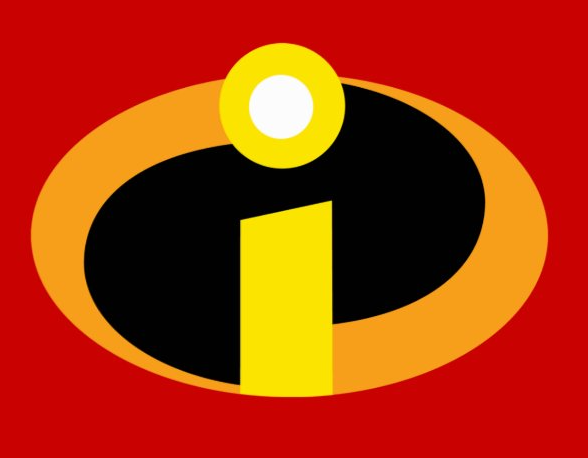

In [5]:
from google.colab.patches import cv2_imshow
image = cv2.imread('incredibles.png')

cv2_imshow(image)

# For matplotlib 
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
genetic = Genetic(150, 10000, image, {'shape':'mixed', 'nbr_of_shapes': 300, 'resolution':25.})
genetic.alternative = True
genetic.genetic()